# **Final Project in Integrated Energy Grids - 46770**

# F.
### Connect your country with, at least, two neighbouring countries. 
You can connect them using HVAC lines, HVDC links or gas pipelines. Use a linear representation of power flow or gas flow. 
You can assume that the generation capacities in the neighbouring countries are fixed or optimize the whole system. You can also include fixed interconnection capacities or optimize them with the generators' capacities. Discuss your results.

In [1]:
 # Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import gurobipy as gp
from geopy.geocoders import Nominatim

import functions as f
    # This includes e.g. annuity and generator data

#### **We connect GBR to France and Norway**

### Load data that was always used in the previous file. It has been moved to a .py-file for simplicity.

In [ ]:
# Read wind, solar, and demand data from the three countries
countries = ['GBR', 'FRA', 'NOR']
year = '2015'
hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                              f'{year}-12-31 23:00Z',
                              freq='h')

########## Initialize network -- to use the snapshots ##########
network_F = pypsa.Network()

# Define snapshots and electricity carrier
network_F.set_snapshots(hours_in_year.values)
network_F.add("Carrier",
              "AC",
              color="black",
              co2_emissions=0)

########## Continue loading data ##########
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

# Load data for the capacity factors and define lists useful for dynamic definition of carriers and generators
CF_wind = {country:
           df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network_F.snapshots]]
           for country in countries}
CF_solar = {country:
            df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network_F.snapshots]]
            for country in countries}
CFs = [CF_wind, CF_solar]

# Useful lists and dict
VRE_techs = ['onshorewind', 'solar']
CF_dict = {'onshorewind': CF_wind, 'solar': CF_solar}
techs_labels = ['onshorewind', 'solar', 'OCGT', 'coal', 'nuclear', 'biomass'] # NG plant = natural gas plant
techs_labels_storageunits = ['Carnot battery (Molten salt)', 'Li-ion battery', ' Vanadium rfb']
carriers =     ['onshorewind', 'solar', 'gas',  'coal', 'nuclear', 'wood chips']
techs_colors = ['blue',        'orange','brown','grey', 'purple',  'green']

(dict_capital_costs_annualized,
 dict_marginal_costs,
 dict_efficiencies,
 CO2_emissions
) = f.load_generator_data(techs_labels)
    # The "techs_labels" is not actually dynamic. 
    # Don't just change the technologies used!!!

(dict_capital_costs_annualized_storageunits,
 efficiencies_in,
 efficiencies_out,
 Crates,
 hourly_losses
) = f.load_storage_units_data(techs_labels_storageunits)
    # The "techs_labels_storageunits" is not actually dynamic. 
    # Don't just change the technologies used!!!

<Axes: title={'center': 'Capacity factors of ONSHORE WIND'}, xlabel='utc_time'>

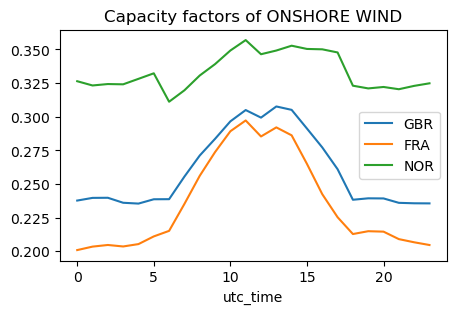

In [3]:
df_w=pd.DataFrame(CFs[0])
df_w.groupby(df_w.index.hour).mean().plot(title='Capacity factors of ONSHORE WIND',figsize=(5,3))

<Axes: title={'center': 'Capacity factors of SOLAR'}, xlabel='utc_time'>

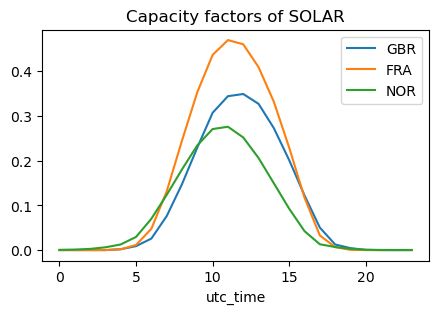

In [4]:
df_s=pd.DataFrame(CFs[1])
df_s.groupby(df_s.index.hour).mean().plot(title='Capacity factors of SOLAR',figsize=(5,3))

<Axes: title={'center': 'Electricity demand'}, xlabel='utc_time', ylabel='MW'>

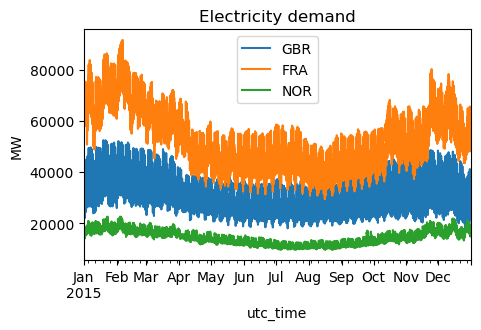

In [5]:
df_elec[countries].plot(title='Electricity demand',ylabel=('MW'),figsize=(5,3))

In [6]:
# Get the coordinates of the countries to use for plotting. Additional countries included for dynamic reasons.
country_coords = {  # a fully set of coordinates is probably available somewhere online
    'GBR': (52.5, -1.5),
    'FRA': (46.5, 2.5),
    'NOR': (61.0, 10.0),
    'PRT': (38.74, -9.15),
    'DNK': (55.67, 12.57)
}

### Define the network using the data from the previous cell

In [7]:
# Define carriers
network_F.add("Carrier", carriers, color=techs_colors, co2_emissions=CO2_emissions, overwrite=True)

for country in countries:
    # Define BUSes
    network_F.add("Bus",
                  f"{country} electricity bus",
                  y=country_coords[country][0],
                  x=country_coords[country][1],
                  carrier="AC",
                  overwrite=True)
    
    # Define electricity LOADs
    network_F.add("Load",
                f"{country} electricity load",
                carrier="AC",
                bus=f"{country} electricity bus",
                p_set=df_elec[country].values,
                overwrite=True)

    # Define GENERATORs
    for i,tech in enumerate(techs_labels):
        network_F.add("Generator",
                      f"{country} {tech}",
                      bus=f"{country} electricity bus",
                      p_nom_extendable=True,
                      #p_nom_extendable=(False if tech=='biomass' and country!='GBR' else True), # to compare with task D)
                      carrier=carriers[i],
                      capital_cost = dict_capital_costs_annualized[tech],
                      marginal_cost = dict_marginal_costs[tech],
                      p_max_pu = (CFs[i][country].values if tech in VRE_techs else 1),
                      efficiency = dict_efficiencies[tech],
                      overwrite=True) # kept  in case of re-running the code

    # Define STORAGEs
    for i, storage in enumerate(techs_labels_storageunits):
        network_F.add("StorageUnit",
                      f"{country} {storage}",
                      bus=f"{country} electricity bus",
                      p_nom_extendable=True,
                      carrier="AC",
                      capital_cost=dict_capital_costs_annualized_storageunits[storage],
                      efficiency_store=efficiencies_in[storage],
                      efficiency_dispatch=efficiencies_out[storage],
                      max_hours=1/Crates[i],
                      cyclic_state_of_charge=True,
                      standing_loss=hourly_losses[storage],  # <- this value quantitatively indicates whether storage is diurnal/seasonal
                      overwrite=True) # for re-running the code

### Before defining the **hydro** storage we need to get some data:

In [8]:
# Find hydro inflows from: https://github.com/martavp/integrated-energy-grids/blob/main/integrated-energy-grids/Problems/data/inflow/Hydro_Inflow_FR.csv
hydro_countries = countries

df_inflow = {}

for hydro_country in hydro_countries:
    df_inflow[hydro_country] = pd.read_csv(f"data/Hydro_Inflow_{hydro_country}.csv")
    df_inflow[hydro_country]['Date'] = pd.to_datetime(df_inflow[hydro_country][['Year', 'Month', 'Day']])
    df_inflow[hydro_country].set_index('Date', inplace=True)  # allows us to choose a year

Date
2003    Axes(0.125,0.11;0.775x0.77)
2004    Axes(0.125,0.11;0.775x0.77)
2005    Axes(0.125,0.11;0.775x0.77)
2006    Axes(0.125,0.11;0.775x0.77)
2007    Axes(0.125,0.11;0.775x0.77)
2008    Axes(0.125,0.11;0.775x0.77)
2009    Axes(0.125,0.11;0.775x0.77)
2010    Axes(0.125,0.11;0.775x0.77)
2011    Axes(0.125,0.11;0.775x0.77)
2012    Axes(0.125,0.11;0.775x0.77)
Name: Inflow [GWh], dtype: object

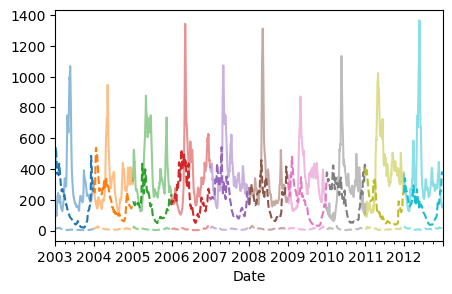

In [9]:
df_inflow["NOR"]['Inflow [GWh]'].groupby(df_inflow[hydro_country].index.year).plot(figsize=(5,3), alpha=0.5)
df_inflow["FRA"]['Inflow [GWh]'].groupby(df_inflow[hydro_country].index.year).plot(figsize=(5,3), linestyle='--')
df_inflow["GBR"]['Inflow [GWh]'].groupby(df_inflow[hydro_country].index.year).plot(figsize=(5,3), alpha=0.5, linestyle='--')

In [10]:
hydro_countries = ['FRA', 'NOR']  # UK has barely any hydro...
df_inflow_hourly = pd.DataFrame({hydro_country:np.zeros(8760) for hydro_country in hydro_countries}, index=hours_in_year)
hydro_year = 2010
for hydro_country in hydro_countries:
    df_inflow_hourly.loc[::24,hydro_country] = (df_inflow[hydro_country][df_inflow[hydro_country].index.year==hydro_year]['Inflow [GWh]'] * 1e3).values  # GWh -> MWh
print(df_inflow_hourly.head(26))

                                FRA       NOR
2015-01-01 00:00:00+00:00  347679.0  145695.0
2015-01-01 01:00:00+00:00       0.0       0.0
2015-01-01 02:00:00+00:00       0.0       0.0
2015-01-01 03:00:00+00:00       0.0       0.0
2015-01-01 04:00:00+00:00       0.0       0.0
2015-01-01 05:00:00+00:00       0.0       0.0
2015-01-01 06:00:00+00:00       0.0       0.0
2015-01-01 07:00:00+00:00       0.0       0.0
2015-01-01 08:00:00+00:00       0.0       0.0
2015-01-01 09:00:00+00:00       0.0       0.0
2015-01-01 10:00:00+00:00       0.0       0.0
2015-01-01 11:00:00+00:00       0.0       0.0
2015-01-01 12:00:00+00:00       0.0       0.0
2015-01-01 13:00:00+00:00       0.0       0.0
2015-01-01 14:00:00+00:00       0.0       0.0
2015-01-01 15:00:00+00:00       0.0       0.0
2015-01-01 16:00:00+00:00       0.0       0.0
2015-01-01 17:00:00+00:00       0.0       0.0
2015-01-01 18:00:00+00:00       0.0       0.0
2015-01-01 19:00:00+00:00       0.0       0.0
2015-01-01 20:00:00+00:00       0.

In [11]:
capital_cost_hydro_annualized = f.load_hydro_cost()  # €/MW/a
capital_cost_hydro_annualized*1, dict_capital_costs_annualized  # it's rather cheap compared to the other technologies

(109128.85760044833,
 {'onshorewind': 110644.32615672055,
  'solar': 22980.056511694245,
  'OCGT': 38447.402240719224,
  'coal': 197904.8110235642,
  'nuclear': 695334.7173583676,
  'biomass': 273992.9814855853})

In [12]:
# Hydro storage in Norway and France:
network_F.add("Carrier",
              "water",
              color="cyan",
              co2_emissions=0,
              overwrite=True)

for hydro_country in hydro_countries:
    network_F.add("Bus",
                  f"{hydro_country} water bus",
                  y=country_coords[hydro_country][0],
                  x=country_coords[hydro_country][1],
                  carrier="water",
                  overwrite=True)

    network_F.add("Store",
                  f"{hydro_country} water reservoir",
                  bus=f"{hydro_country} water bus",
                  e_nom=0, # CHANGED2
                  e_nom_extendable=True, # CHANGED2
                  e_cyclic=True,  # CHANGED2 initial energy is the energy at the final snapshot
                  marginal_cost=0,
                  capital_cost=0,  # costs are modelled as $/kW on the link instead
                  standing_loss=0,  # this seems a reasonable assumption
                  overwrite=True)

    network_F.add("Link",
                  f"{hydro_country} hydro2p",  # hydro-to-power
                  bus0=f"{hydro_country} water bus",
                  bus1=f"{hydro_country} electricity bus",
                  carrier="water",
                  efficiency=1,  # the power is assumed to have been given in MWh_e
                  p_nom=0,
                  p_nom_extendable=True,
                  #p_nom_extendable=False, # to compare with task D)
                  p_nom_max=26712,  # Assumed to be the current level: from 'ENTSO-E Transparency Platform - Installed Capacity per Production Type'
                  marginal_cost=0,  # assumption, it might be too rough
                  capital_cost=capital_cost_hydro_annualized, # CHANGED2
                  overwrite=True)

    # dummy components because generator couldn't work...
    network_F.add("Bus",
                  f"dummy {hydro_country} water bus",
                  y=country_coords[hydro_country][0],
                  x=country_coords[hydro_country][1],
                  carrier="water",
                  overwrite=True)

    network_F.add("Store",  # A generator component is used to simulate the water inflow
                 f"dummy {hydro_country} water inflow",
                 bus=f"dummy {hydro_country} water bus",
                 e_nom=df_inflow_hourly[hydro_country].values.flatten().sum(),
                 e_nom_extendable=False,
                 e_initial=df_inflow_hourly[hydro_country].values.flatten().sum(),
                 marginal_cost=0,
                 capital_cost=0,
                 standing_loss=0,
                 overwrite=True)

    network_F.add("Link",
                f"dummy {hydro_country} hydro2p",  # hydro-to-power
                bus0=f"dummy {hydro_country} water bus",
                bus1=f"{hydro_country} water bus",
                carrier="water",
                efficiency=1,  # the power is already given in MWh_e
                p_nom=max(df_inflow_hourly[hydro_country].values.flatten()),
                p_max_pu=df_inflow_hourly[hydro_country].values.flatten() / max(df_inflow_hourly[hydro_country].values.flatten()),
                p_nom_extendable=False,
                marginal_cost=0,  # assumption, it might be too rough
                capital_cost=0,
                overwrite=True)

In [13]:
# CABLE
# Assuming a line between the first and all other countries
line_pairs = [(countries[0],country1) for country1 in countries[1:]]
distances = {f"({line_pair[0]},{line_pair[1]})":dist for line_pair,dist in zip(line_pairs,[73, 730])}  # km, from https://en.wikipedia.org/wiki/HVDC_Cross-Channel, https://en.wikipedia.org/wiki/North_Sea_Link

# This Energinet note states that the Viking Link cost 15 bDKK and that its capacity is 1400 MW.
#   Given the distance of 621 km we can determine a cost per MW per km. By annualizing afterwards and multiplying by distance, we'll arrive at €/MW/a.
DKK2Euro = 1/7.5
cable_cost_per_km = 15e9*DKK2Euro / 1400 / 621  # €/MWkm
lifetime_cable = 40  # years according to the relevant Technology Catalogue from the DEA
capital_cost_cable_annualized = {f"({line_pair[0]},{line_pair[1]})":
                                 f.annuity(lifetime_cable, 0.07)
                                 *distances[f"({line_pair[0]},{line_pair[1]})"]
                                 *cable_cost_per_km
                                 *(1+0.03)
                                 for line_pair in line_pairs}  # €/MW/a

# Define LINEs
for line_pair in line_pairs:
    network_F.add(
        "Line",
        f"({line_pair[0]},{line_pair[1]})",
        bus0=f"{line_pair[0]} electricity bus",
        bus1=f"{line_pair[1]} electricity bus",
        length=distances[f"({line_pair[0]},{line_pair[1]})"],
        s_nom=0,
        s_nom_extendable=True,
        #s_nom_extendable=False,  # to compare with task D)
        x=1,
        r=1,
        capital_cost=capital_cost_cable_annualized[f"({line_pair[0]},{line_pair[1]})"],
        overwrite=True
    )

In [30]:
capital_cost_cable_annualized, capital_cost_hydro_annualized, dict_capital_costs_annualized, dict_capital_costs_annualized_storageunits

({'(GBR,FRA)': 12974.320570293905, '(GBR,NOR)': 129743.20570293903},
 109128.85760044833,
 {'onshorewind': 110644.32615672055,
  'solar': 22980.056511694245,
  'OCGT': 38447.402240719224,
  'coal': 197904.8110235642,
  'nuclear': 695334.7173583676,
  'biomass': 273992.9814855853},
 {'Carnot battery (Molten salt)': 37121.629749659936,
  'Li-ion battery': 116667.97921321695,
  ' Vanadium rfb': 143892.57600301894})

In [14]:
# Keep track of biomass usage

# Before we used: 
'''
PJ2MWh = 10**9 / 60**2
biomass_imported = 0.4
biomass_available = 294 * PJ2MWh * (1-biomass_imported)  # MWh_th
'''

# But now we want to make it more DYNAMIC:
    # We limit the use of wood chips by:
    # 1) assuming that all solid biomass is wood chips. Simply referred to as "biomass" in script.
    # 2) assuming that all internally produced solid biomass (97.5% of solid biomass consumption) is sustainable and all imported is not and thus forbidden
    # 3) assuming that the 4.2 EJ of solid biomass is in thermal/raw units (MWh_h)
    # Using 2024 numbers from https://www.ieabioenergy.com/wp-content/uploads/2025/01/CountryReport2024_EU27_final_v2.pdf
EJ2MWh = 10**12 / 60**2  # purely unit conversion factor
biomass_imported_EU = 0.025
biomass_available_EU = 4.2 * EJ2MWh * (1-0.025)  # MWh_th
# We assume that biomass has the same potential to grow anywhere in Europe and so the EU numbers 
#   can be used to determine a biomass per land area-factor by weighting the country sizes
country_sizes = pd.read_csv('data/country_sizes.csv')
country_sizes.index = country_sizes['code']
biomass_density = biomass_available_EU / country_sizes['area'][country_sizes['EU']==True].sum()  # MWh/km2
biomass_available = biomass_density * country_sizes.loc[countries]['area'].sum()  # MWh
#biomass_available = biomass_density * country_sizes.loc['GBR']['area'].sum()  # MWh
    # Replace 'countries' with 'GBR' and also avoid biomass 
    #   investments from neighbours, in order to get the same
    #   optimization result as obtained in task D).

network_F.carriers["track_biomass"] = [0, 0, 0, 0, 0, 0, 1.0, 0]  # count 1 MWh for each MWh of wood chips used and none for the others

network_F.add(
    "GlobalConstraint",
    "BiomassLimit",
    carrier_attribute="track_biomass",
    sense="<=",
    constant=biomass_available,
    overwrite=True
)

Index(['BiomassLimit'], dtype='object')

In [15]:
CO2_1990 = {}
CO2_1990["GBR"] = round(406.2*0.14/0.27, 1)  # MtCO2 -- this is the limit used generally throughout the project -- see source in the report
CO2_1990["FRA"] = round(396 * 0.09 / (1-0.55), 1)  # from https://www.statistiques.developpement-durable.gouv.fr/edition-numerique/chiffres-cles-du-climat/fr/donnees-cles
CO2_1990["NOR"] = round(41.7 * 0.2 / 1.12) # Assumption: "stationary combustion"="electricity/heat sector"

emissions_reduction = 1-0.98

# Adding the CO2 constraint: even w/o this constraint the cost-optimal solution only results in 54.3 MtCO2/a. That's pretty low.
network_F.add("GlobalConstraint",
              "CO2Limit",
              carrier_attribute="co2_emissions",
              sense="<=",
              constant=np.sum(list(CO2_1990.values())) * emissions_reduction * 1e6,  # tCO2
              overwrite=True
              )
network_F.global_constraints.constant

GlobalConstraint
BiomassLimit    3.231909e+08
CO2Limit        5.936000e+06
Name: constant, dtype: float64

In [16]:
env = gp.Env(empty=True) # Initialize a gurobipy-environment in which we can disable unnecessary outputs
env.setParam("OutputFlag", 0)  # Fully disable output
env.start()

network_F.optimize(solver_name='gurobi', solver_options={"env": env})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 13/13 [00:01<00:00,  8.21it/s]
INFO:linopy.io: Writing time: 11.25s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 516873 primals, 1138837 duals
Objective: 4.35e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [17]:
network_F.objective/1e9  # € -> b€ -- it was 47.935 b€ before adding hydro for France :O ... 42.82 before adding CO2 constraint

43.50324824717502

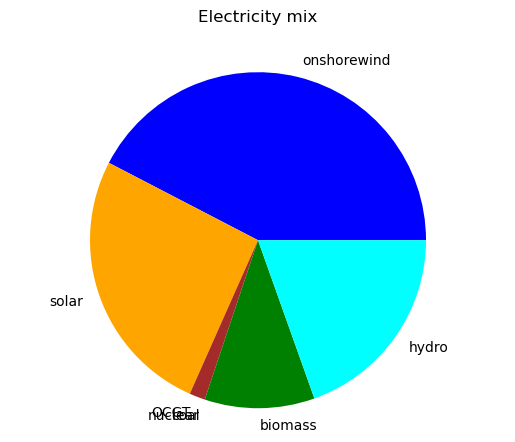

In [18]:
sizes_F = [np.array([network_F.generators_t.p[f"{country} {tech}"].sum()
        for country in countries]).sum()
        for tech in techs_labels]
sizes_F_hydro = network_F.links_t.p0[[f"{hydro_country} hydro2p" for hydro_country in hydro_countries]].sum().sum()
sizes_F.append(sizes_F_hydro)

plt.pie(sizes_F,
        colors=techs_colors+[network_F.carriers.color['water']],
        labels=techs_labels+['hydro'],
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)
plt.savefig('results/F/electricity_mix.png', dpi=500)

In [19]:
network_F.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
GBR onshorewind     52.243818
GBR solar            0.000000
GBR OCGT            18.867990
GBR coal             0.000000
GBR nuclear          0.000000
GBR biomass          0.000000
FRA onshorewind     44.003029
FRA solar          211.239370
FRA OCGT            19.093557
FRA coal             0.000000
FRA nuclear          0.000000
FRA biomass         15.200372
NOR onshorewind     70.953752
NOR solar            0.000000
NOR OCGT             0.000000
NOR coal             0.000000
NOR nuclear          0.000000
NOR biomass          0.000000
Name: p_nom_opt, dtype: float64

In [20]:
network_F.storage_units.p_nom_opt.div(1e3)  # MW -> GW

StorageUnit
GBR Carnot battery (Molten salt)     0.773579
GBR Li-ion battery                   0.000000
GBR  Vanadium rfb                    0.000000
FRA Carnot battery (Molten salt)    32.300932
FRA Li-ion battery                   0.000000
FRA  Vanadium rfb                    0.000000
NOR Carnot battery (Molten salt)     1.205213
NOR Li-ion battery                   0.000000
NOR  Vanadium rfb                    0.000000
Name: p_nom_opt, dtype: float64

In [21]:
network_F.lines.s_nom_opt.div(1e3)  # MW -> GW

Line
(GBR,FRA)    27.613344
(GBR,NOR)    29.029622
Name: s_nom_opt, dtype: float64

In [22]:
network_F.links.p_nom_opt.div(1e3)  # MW -> GW

Link
FRA hydro2p            26.712000
dummy FRA hydro2p     440.812000
NOR hydro2p            25.025645
dummy NOR hydro2p    1134.550000
Name: p_nom_opt, dtype: float64

In [23]:
# emissions by CARRIER
emissions = (
    network_F.generators_t.p
    / network_F.generators.efficiency
    * network_F.generators.carrier.map(network_F.carriers.co2_emissions)
).T.groupby(network_F.generators.carrier).sum().T  # t/h
emissions.sum().div(1e6), emissions.sum().div(1e6).sum().round(3)  # tCO2 -> MtCO2

(carrier
 coal           0.000
 gas            5.936
 nuclear        0.000
 onshorewind    0.000
 solar          0.000
 wood chips     0.000
 dtype: float64,
 5.936)

In [24]:
np.array([network_F.generators_t.p[f"{country} biomass"].sum() for country in countries]).sum() / 10**6, biomass_available / 10**6 * dict_efficiencies['biomass']  # in TWh. Compare the biomass used to the biomass available to verify if we are using everything

(98.57322767047387, 98.57322767051916)

/opt/anaconda3/envs/integrated-energy-grids/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


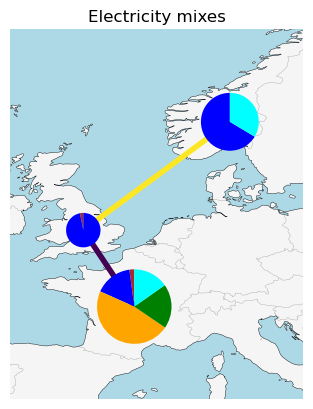

/opt/anaconda3/envs/integrated-energy-grids/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


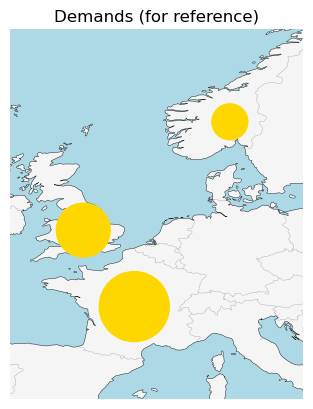

/opt/anaconda3/envs/integrated-energy-grids/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


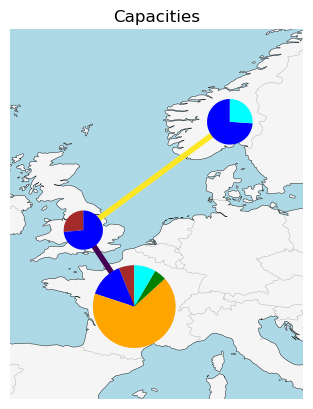

In [25]:
sizes_F_ind_gen = network_F.generators_t.p.sum().groupby([network_F.generators.bus, network_F.generators.carrier]).sum()
sizes_F_ind_hydro = network_F.links_t.p0.sum().groupby([network_F.links.bus1, network_F.links.carrier]).sum()[(network_F.links.p_nom == 0).values]
sizes_F_ind = pd.concat([sizes_F_ind_gen, sizes_F_ind_hydro])
ax = network_F.plot(margin=0.5,
                    bus_sizes=sizes_F_ind / 6e7,
                    color_geomap=True,
                    line_widths=4,
                    line_colors=network_F.lines_t.p0.abs().mean(),
)
plt.title("Electricity mixes")
plt.savefig('results/F/electricity_mixes_map.png', dpi=500)
plt.show()

sizes_F_load = network_F.loads_t.p.sum().groupby([network_F.loads.bus, network_F.loads.carrier]).sum()
ax = network_F.plot(margin=0.5,
                    bus_sizes=sizes_F_load / 6e7,
                    color_geomap=True,
                    line_widths=0,
                    line_colors=network_F.lines.s_nom_opt,
)
plt.title("Demands (for reference)")
plt.savefig('results/F/Demands_map.png', dpi=500)
plt.show()

sizes_F_ind_gen_nom = network_F.generators.p_nom_opt.groupby([network_F.generators.bus, network_F.generators.carrier]).sum()
sizes_F_ind_hydro_nom = network_F.links.p_nom_opt.groupby([network_F.links.bus1, network_F.links.carrier]).sum()[(network_F.links.p_nom == 0).values]
sizes_F_ind_nom = pd.concat([sizes_F_ind_gen_nom, sizes_F_ind_hydro_nom])
ax = network_F.plot(margin=0.5,
                    bus_sizes=sizes_F_ind_nom / 3e4,
                    color_geomap=True,
                    line_widths=4,
                    line_colors=network_F.lines.s_nom_opt,
)
plt.title("Capacities")
plt.savefig('results/F/capacities_map.png', dpi=500)
plt.show()

In [26]:
# Congestion rent
-np.round(np.array([network_F.lines_t.p0[f"({line_pair[0]},{line_pair[1]})"].multiply(
    network_F.buses_t.marginal_price[f"{line_pair[0]} electricity bus"]
    -network_F.buses_t.marginal_price[f"{line_pair[1]} electricity bus"]
).sum() / 1e6
for line_pair in line_pairs]).sum(),3)

4124.661

In [27]:
# Total expenditures, of which 'AC' is transmission and storage:
tot_expenditures=(network_F.statistics.capex(groupby="carrier").add(
    network_F.statistics.opex(groupby="carrier"), fill_value=0
    )
).div(1e6).round(3)  # € -> M€
tot_expenditures, tot_expenditures.sum(), network_F.objective/1e6

(component    carrier    
 Generator    gas             2734.163
              onshorewind    18499.798
              solar           4854.293
              wood chips      6371.745
 Line         AC              4124.661
 Link         water           5646.070
 StorageUnit  AC              1272.519
 dtype: float64,
 43503.249,
 43503.248247175026)

In [28]:
# Storage profits
bus_price = network_F.buses_t.marginal_price
stor_p = network_F.storage_units_t.p
stor_bus = network_F.storage_units.bus
( stor_p * bus_price[stor_bus].to_numpy() ).sum().div(1e6).round(3).sum()  # € -> M€

1272.5190000000002

In [29]:
# Generator profits by CARRIER and GENERATOR, respectively
gen_p = network_F.generators_t.p
gen_bus = network_F.generators.bus

( gen_p * bus_price[gen_bus].to_numpy() ).sum().div(1e6).groupby(network_F.generators.carrier).sum().round(3), ( gen_p * bus_price[gen_bus].to_numpy() ).sum().div(1e6).round(3)  # € -> M€

(carrier
 coal               0.000
 gas             3933.109
 nuclear            0.000
 onshorewind    18499.798
 solar           4854.293
 wood chips      7745.488
 dtype: float64,
 Generator
 GBR onshorewind    5780.482
 GBR solar             0.000
 GBR OCGT           1328.462
 GBR coal              0.000
 GBR nuclear           0.000
 GBR biomass           0.000
 FRA onshorewind    4868.685
 FRA solar          4854.293
 FRA OCGT           2604.647
 FRA coal              0.000
 FRA nuclear           0.000
 FRA biomass        7745.488
 NOR onshorewind    7850.630
 NOR solar             0.000
 NOR OCGT              0.000
 NOR coal              0.000
 NOR nuclear           0.000
 NOR biomass           0.000
 dtype: float64)

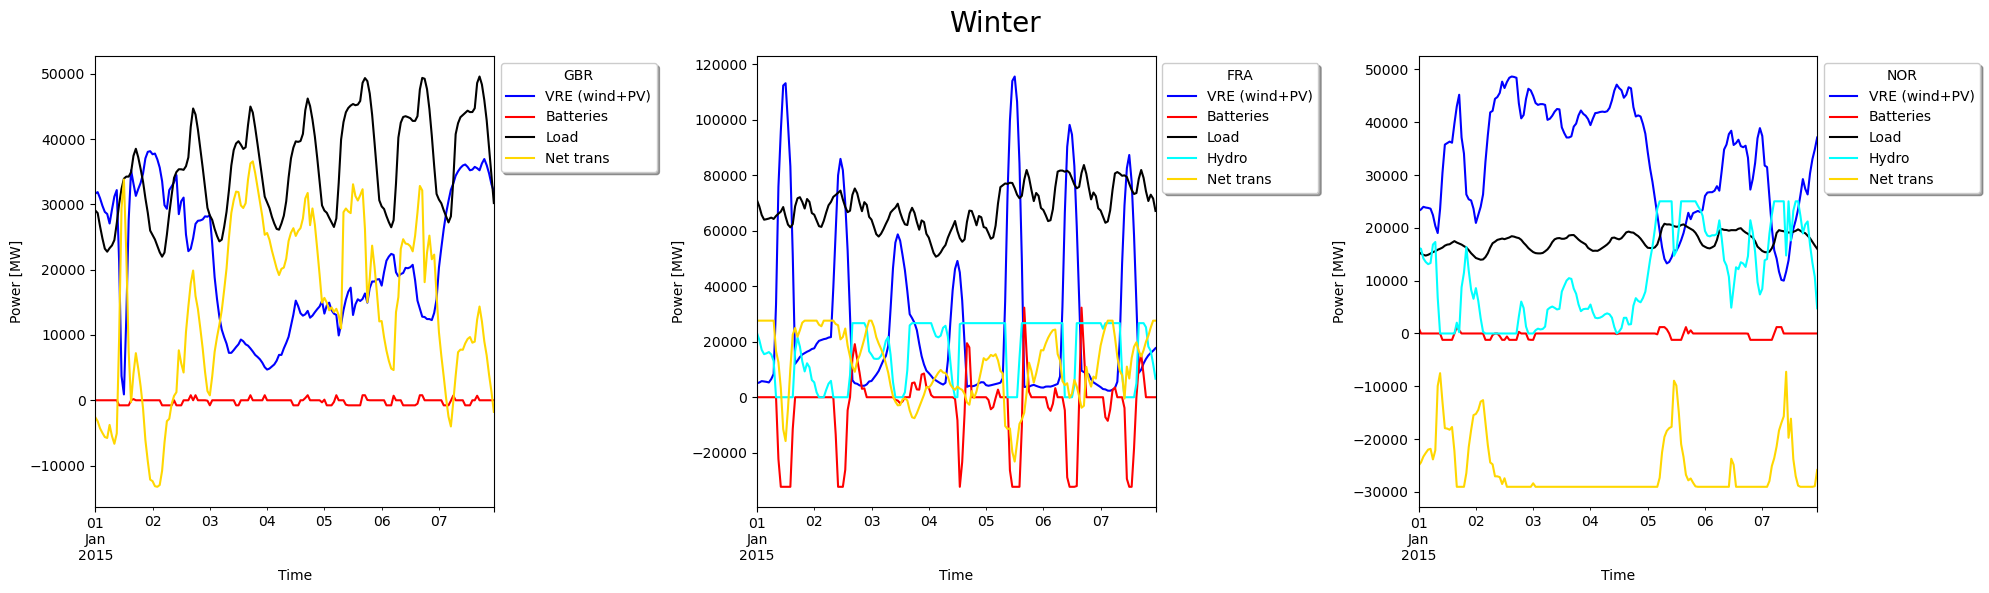

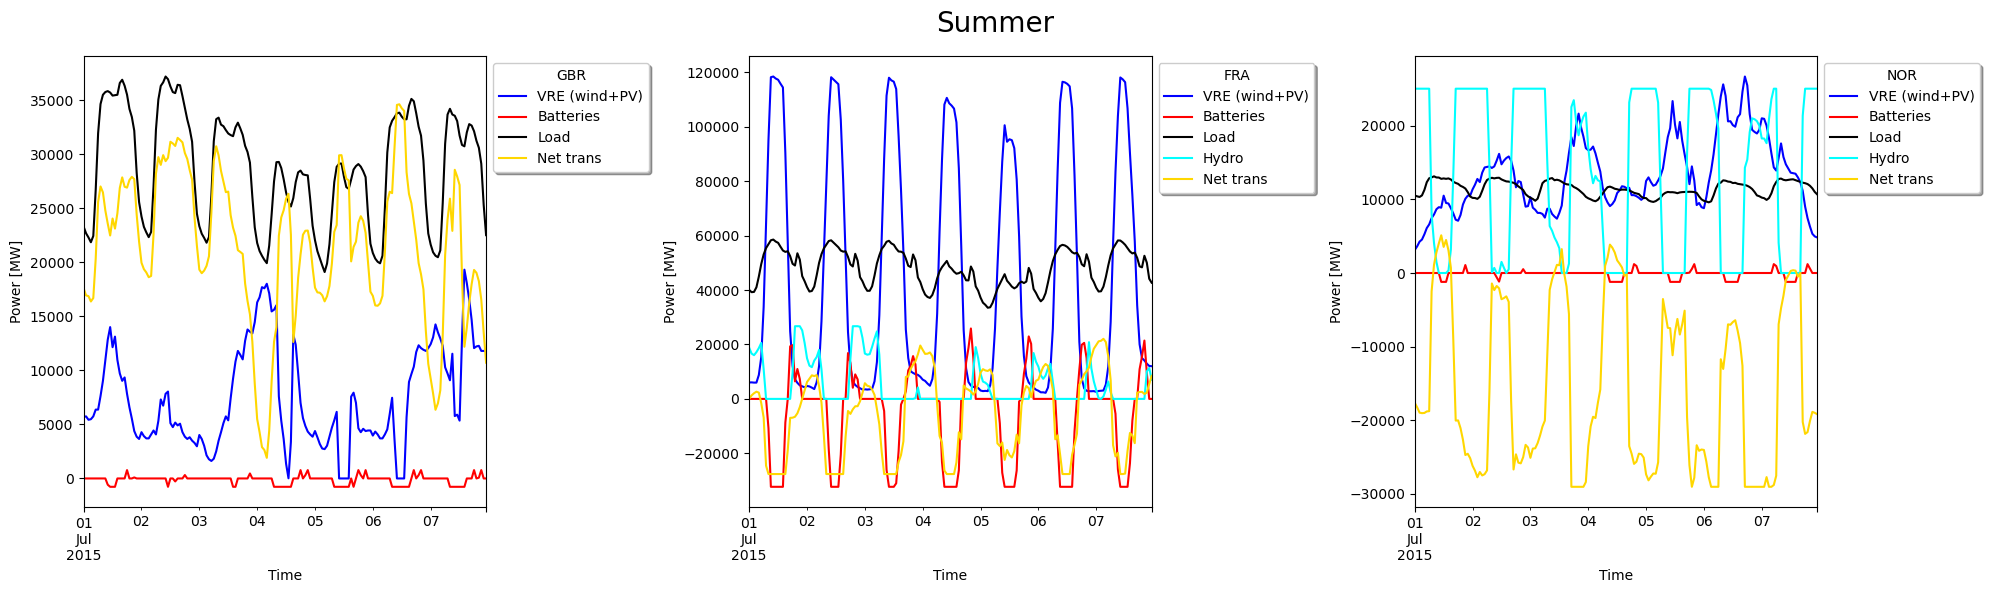

In [137]:
start_dates = ["2015-01-01", "2015-07-01"]
end_dates = ["2015-01-07", "2015-07-07"]
seasons = ['Winter', 'Summer']

storage_colors = ['red', 'yellow','pink']

#trans_export = {}
#trans_import = {}

for j, season in enumerate(seasons):
    fig, ax = plt.subplots(1,len(countries),figsize=(20,6))
    for i, country in enumerate(countries):
        network_F.generators_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {tech}" for tech in VRE_techs]].T.sum().plot(
            ax=ax[i],
            label="VRE (wind+PV)",
            color=network_F.generators.carrier.map(network_F.carriers.color)[f"{country} {VRE_techs[0]}"],  # choose solar or wind color
            legend=False)
        # network_F.generators_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {tech}" for tech in VRE_techs]].plot(ax=ax[i], legend=False)  # to see VREs separately
        network_F.storage_units_t.p.loc[start_dates[j]:end_dates[j]][[f"{country} {stor}" for stor in techs_labels_storageunits]].T.sum().plot(
            ax=ax[i],
            label="Batteries",
            color=storage_colors[0], # oops, the carriers for storages are not defined #network_F.storage_units.carrier.map(network_F.carriers.color)[f"{country} {techs_labels_storageunits[-1]}"],  # choose one of their colors
            legend=False)
        network_F.loads_t.p.loc[start_dates[j]:end_dates[j]][f"{country} electricity load"].plot(
            ax=ax[i],
            label="Load",
            color=network_F.loads.carrier.map(network_F.carriers.color)[f"{country} electricity load"],
            legend=False)
        if country in hydro_countries:
            network_F.links_t.p0.T[(network_F.links.p_nom == 0).values].T.loc[start_dates[j]:end_dates[j]][f"{country} hydro2p"].plot(
                ax=ax[i],
                label="Hydro",
                color=network_F.links.carrier.map(network_F.carriers.color)[f"{country} hydro2p"],
                legend=False)  # p_nom==0 because we don't care about "dummy" links
        
        combined_export = pd.Series(0, index=network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)
        combined_import = pd.Series(0, index=network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]].index)

        for bus0, bus1 in line_pairs:
            if bus0 == country:
                combined_export += network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]
                # network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]].multiply(-1)[f"({bus0},{bus1})"].plot(
                #     ax=ax[i],
                #     label=f"Cable: ({bus0},{bus1})",
                #     color='gold',
                #     legend=False)
            if bus1 == country:
                combined_import += network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"]
                # network_F.lines_t.p0.loc[start_dates[j]:end_dates[j]][f"({bus0},{bus1})"].plot(
                #     ax=ax[i],
                #     label=f"Cable: ({bus0},{bus1})",
                #     color="gold",
                #     legend=False)

        net_transmission = combined_import - combined_export
        net_transmission.plot(
                              ax=ax[i],
                              label="Net trans",
                              color='gold',
                              legend=False
                              )

        ax[i].legend(loc='best', fancybox=True, shadow=True, bbox_to_anchor=(1, 1), prop={'size': 10}, title=f"{country}")
        ax[i].set_ylabel('Power [MW]')
        ax[i].set_xlabel('Time')
    plt.suptitle(f"{season}", fontsize=20)
    plt.tight_layout()
    #plt.savefig(f'results/D/dispatch_{season}', dpi=500)
    plt.show()


In [125]:
trans_export

{}